# Köpekler ve Kediler Görüntü Sınıflandırması (Veri Seti Büyütme İle)

Bu başlık altında, resimlerdeki kedi ve köpek resimlerini nasıl sınıflandıracağımızı bulacağız. `tf.keras.Sequential` modelini kullanarak bir görüntü sınıflandırıcı oluşturacağız. Bununla beraber `tf.keras.preprocessing.image.ImageDataGenerator` veri setlerimizi yükleyeceğiz.

## Başlamadan Bakmamız Gereken Birkaç Bilgi
Bu colab dosyası ile pratik bir deneyim elde etmiş olacağız.
* `tf.keras.preprocessing.image.ImageDataGenerator` sınıfını kullanarak veri girişini nasıl alacağız? Modelimizi oluşturmak için diskteki verileri nasıl verimli bir şekilde çalıştırabiliriz?

* Aşırı uyum (*overfitting*) nedir?

<hr>

**Başlamadan önce**

Kod satırlarını bu not defterinde çalıştırmadan önce, yukarıdaki menüden Çalışma Zamanı -> Çalışma Zamanını Yeniden Başlat seçeneklerini takip ederek çalışma zamanını sıfırlayın. Bunu yapmamız, Colab'ın bellek sınırlarına ulaşmaktan kaçınmamıza yardımcı olacaktır.


## Paketlerin İçe Aktarılması

Gerekli paketleri içe aktararak başlayalım:

* os — dosyaları ve dizin yapısını okumak için kullanılır.
* numpy — TensorFlow'un dışındaki bazı matris matematiği için gereklidir.
* matplotlib.pyplot —  grafikleri, eğitim ve doğrulama verilerimizi görüntülemek için kullanılır.

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [6]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Verilerin Yüklenmesi

Görüntü sınıflandırı oluşturmak için ver setini indirerek başlıyoruz. Kullandığımız veri kümesi, Kaggle'ın <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs. Cats</a> veri kümesi olacak.(Bu veri kümesi Microsoft Research tarafından sağlanmaktadır.)

Önceki colab dosyalarında, veri kümesi kullanmanın çok kolay ve kullanışlı bir yolu olan <a href="https://www.tensorflow.org/datasets" target="_blank">TensorFlow Datasets</a> kullandık. Ancak bu colab dosyasında diskten veri okuyacak olan `tf.keras.preprocessing.image.ImageDataGenerator` sınıfını kullanacağız. Bu nedenle, Dogs vs Cats veri setimizi bir URL'den doğrudan indirmemiz ve dosya sistemine açmamız gerekiyor.

In [7]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 0s 0us/step


İndirmiş olduğumuz veri seti aşağıdaki dizin yapısına sahiptir:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

Dizinleri aşağıdaki terminal komutlarıyla listeleyebiliriz:

In [8]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs


Şimdi eğitim ve doğrulama kümeleri için uygun dosya yolları değişkenlere atayacağız.

In [9]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # eğitim kedi resimlerimizin olduğu dizin
train_dogs_dir = os.path.join(train_dir, 'dogs')  # eğitim köpek resimlerimizin olduğu dizin
validation_cats_dir = os.path.join(validation_dir, 'cats')  # doğrulama kedi resimlerimizin olduğu dizin
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # doğrulama köpek resimlerimizin olduğu dizin

### Verilerimizi Anlayalım

Eğitim ve doğrulama dizinimizde kaç tane kedi ve köpek resmimiz olduğuna bakalım.

In [10]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [11]:
print('Eğitim veri setindeki toplam kedi resmi :', num_cats_tr)
print('Eğitim veri setindeki toplam köpek resmi:', num_dogs_tr)

print('Doğrulama veri setindeki toplam kedi resmi :', num_cats_val)
print('Doğrulama veri setindeki toplam köpek resmi:', num_dogs_val)
print("--")
print("Toplam eğitim veri seti görüntülerimiz :", total_train)
print("Toplam doğrulama veri seti görüntülerimiz : ", total_val)

Eğitim veri setindeki toplam kedi resmi : 1000
Eğitim veri setindeki toplam köpek resmi: 1000
Doğrulama veri setindeki toplam kedi resmi : 500
Doğrulama veri setindeki toplam köpek resmi: 500
--
Toplam eğitim veri seti görüntülerimiz : 2000
Toplam doğrulama veri seti görüntülerimiz :  1000


## Model Parametrelerinin Ayarlanması

Kolaylık sağlaması için daha sonra veri setimizi işlerken ve ağımızı eğitirken kullanılacak değişkenleri tanımlayalım:

In [12]:
BATCH_SIZE = 100  # Model değişkenlerimizi güncellemeden önce işlenecek eğitim örneklerinin sayısı
IMG_SHAPE  = 150  # Eğitim verilerimiz 150 piksel genişliğinde ve 150 piksel yüksekliğinde görüntülerden oluşmaktadır.

## Veri Seti Büyütme

Aşırı uyum (*overfitting*) genellikle az sayıda eğitim örneğimiz olduğunda ortaya çıkar. Bu sorunu çözmenin bir yolu, veri setimizi yeterli sayıda ve çeşitli eğitim örneklerine sahip olacak şekilde genişletmektir. Veri büyütme (*Data Augmentation*) rasgele dönüşümler yoluyla örnekleri çoğaltarak, mevcut eğitim örneklerinden daha fazla eğitim verisi üretme yaklaşımını benimser. Amaç, eğitim sırasında modelimizin aynı resmi asla iki kez görmemesidir. Bu, modeli verilerin daha fazla yönüne maruz bırakarak daha iyi genelleştirmesine olanak tanır.

`tf.keras` sınıfında bunu daha önce kullandığımız `ImageDataGenerator` sınıfını kullanarak uygulayabiliriz. İstediğimiz farklı dönüşümleri bir argüman biçimi olarak veri kümemize geçirebiliriz.

Başlamak için, gerçekleştirilen bütütmenin türünü görebilmek için bir görüntüyü görüntüleyen bir işlev tanımlayalım. Ardından, eğitim sırasında kullanacağımız belirli argümanlara bakalım.

In [13]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Görüntünün Yatay Olarak Çevrilmesi

Veri kümemize rastegele yatay çevirme uyguluyoruz ve sonra tek tek görüntülerin nasıl görüneceğini görerek başlayabiliriz. Bunu, `ImageDataGenerator` sınıfına bir argüman olarak `horizontal_flip = True` ileterek yapabiliriz.

In [14]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


Uygulanmış halini görmek için eğitim setimizden örnek bir resim alıp beş kez tekrarlayalım. Veri attırma, her tekrara rastgele uygulanacaktır (veya uygulanmayabilir).

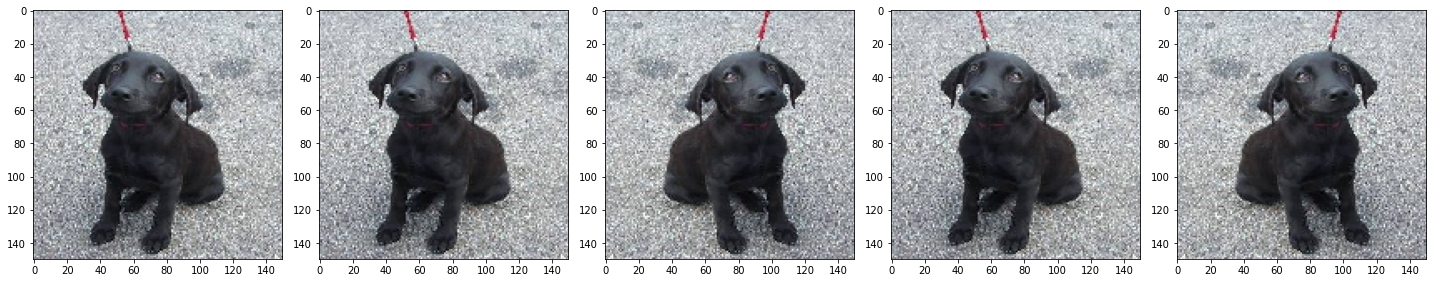

In [15]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Görüntünün Döndürülmesi

Görüntüyü döndürerek veri setini büyütme işlevi, görüntüyü belirli bir dereceye kadar rastgele döndürür. Aşağıdaki kod için bu değeri 45 dereceye ayarlıyoruz.



In [16]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


Uygulanmış halini görmek için eğitim setimizden örnek bir resim alıp beş kez tekrarlayalım. Veri attırma, her tekrara rastgele uygulanacaktır (veya uygulanmayabilir).

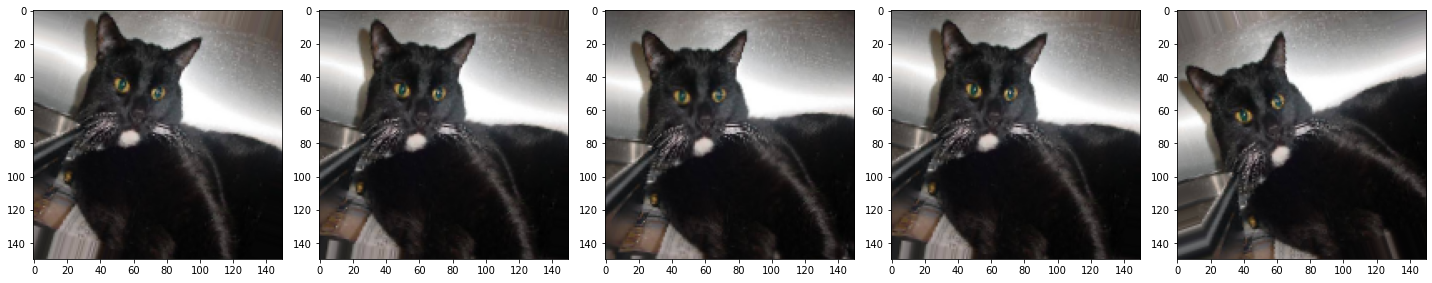

In [17]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Görüntüye Yakınlaştırma Uygulanması

Ayrıca, görüntüleri rastgele %50'ye kadar yakınlaştırarak veri kümemizi büyütebiliriz:

In [18]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))


Found 2000 images belonging to 2 classes.


Uygulanmış halini görmek için eğitim setimizden örnek bir resim alıp beş kez tekrarlayalım. Veri attırma, her tekrara rastgele uygulanacaktır (veya uygulanmayabilir).

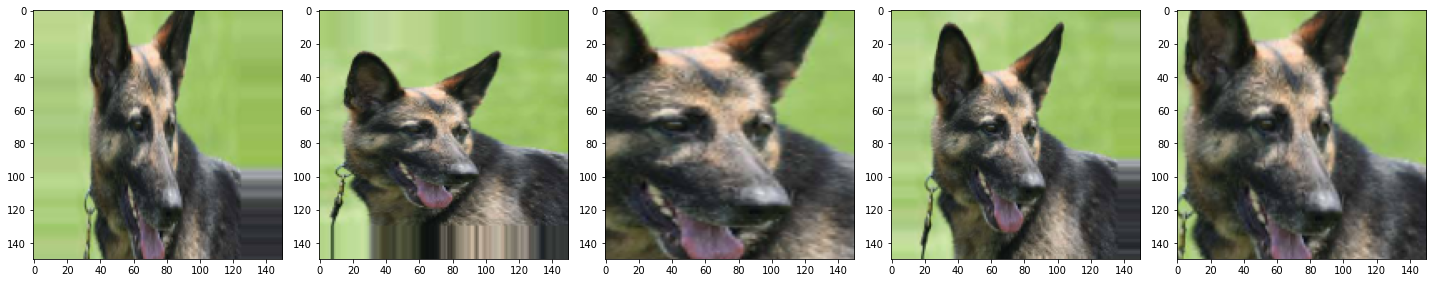

In [19]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Hepsini Bir Arada Uygulayalım

Yukarıdaki büyütmeleri ve hatta yukarıda belirtmediğimiz büyütmeleri uygun değerlere sahip argümanlar olarak ileterek tek bir kod satırı ile uygulayabiliriz.

Aşağıdaki kod bloğunda; yeniden ölçeklendirme, 45 derece döndürme, yatay kaydırma, dikey kaydırma, yatay çevirme ve yakınlaştırma işlevlerini uyguladık.

In [20]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Bu büyütmeleri rastgele bir veri setimize aktardığımızda, tek bir görüntünün beş farklı zamanda nasıl görüneceğini görselleştirelim.

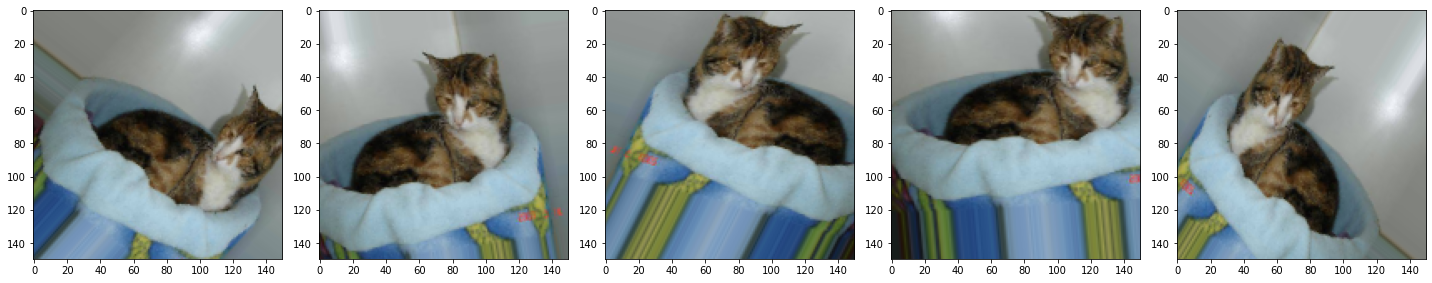

In [21]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## Foğrulama Verisi Oluşturucunun Tanımlanması

Genel olarak, orijinal görüntülerin modelimizin yönetmesi gerekenleri temsil etmesi gerektiği için, yalnızca eğitim örneklerimize veri büyütme uygularız. Bu durumda, yalnızca doğrulama görüntülerimizi yeniden ölçeklendiriyoruz.

In [22]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## Modelin Oluşturulması

### Modelin Tanımlanması

Model, her birinde maksimum havuz katmanı bulunan dört evrişim bloğundan oluşur.

Son yoğun (Dense) katmanlarından önce 0.5'lik bir bırakma (dropout) olasığı uyguluyoruz. Dropout katmanına gelen değerlerin %50'sinin sıfıra ayarlanacağı anlamına gelir. Bu, aşırı uyumu önlemeye yardımcı olacaktır.

Ardından, `relu` yeniden  etkinleştirme işlevine sahip 512 üniteli tam bağlantılı bir katmanımız var. Model, `softmax` kullanarak iki sınıf (köpekler ve kediler) için sınıf olasılıkları çıkaracaktır.

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

### Modelin Derlenmesi

Her zamanki gibi `adam` optimize edici kullanıyoruz. Bir `softmax` kategorizasyonu ürettiğimizde, kayıp fonksiyonu olarak (loss func) `sparse_categorical_crossentropy` kullanacağız. Ayrıca ağımızı eğitirken her bir yineleme de (epoch) eğitim ve doğrulama durumuna bakmak istiyoruz, bu nedenle metrik argümanını `accuracy` (doğruluk) olarak seçiyoruz.

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model Özetimiz

Özet yöntemini kullanarak ağımızın tüm katmanlarına bakalım.

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Modelin Eğitilmesi

Ağımızı eğitme zamanı geldi.

Gruplarımız bir oluşturucudam (ImageDataGenerator), `fit` yerine `fit_generator` kullanacağız.

In [26]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
20/20 [==============================] - 50s 891ms/step - loss: 0.7191 - accuracy: 0.5085 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 17s 850ms/step - loss: 0.6925 - accuracy: 0.5275 - val_loss: 0.6885 - val_accuracy: 0.5120
Epoch 3/100
20/20 [==============================] - 16s 816ms/step - loss: 0.6888 - accuracy: 0.5380 - val_loss: 0.6721 - val_accuracy: 0.6310
Epoch 4/100
20/20 [==============================] - 17s 828ms/step - loss: 0.6859 - accuracy: 0.5495 - val_loss: 0.6798 - val_accuracy: 0.5080
Epoch 5/100
20/20 [==============================] - 18s 887ms/step - loss: 0.6726 - accuracy: 0.5700 - val_loss: 0.6464 - val_accuracy: 0.6190
Epoch 6/100
20/20 [==============================] - 17s 856ms/step - loss: 0.6518 - accuracy: 0.6060 - val_loss: 0.7035 - val_accuracy: 0.5750
Epoch 7/100
20/20 [==============================] - 16s 818ms/step - loss: 0.6480 - accuracy: 0.6085 - val_loss: 0.6262 - val_accuracy:

### Eğitim sonuçlarını görüntüleyelim.

Şimdi ağımızı eğittikten sonra elde ettiğimiz sonuçları görselleştirelim.

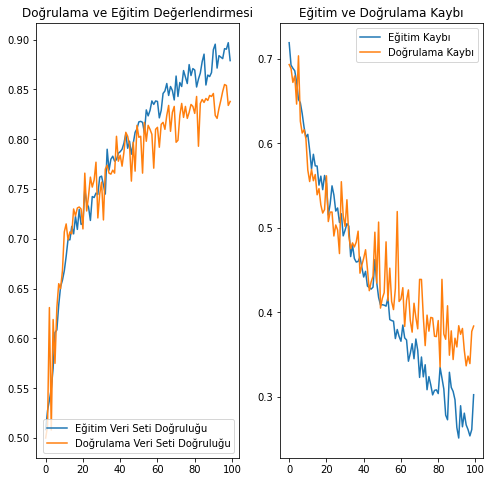

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Veri Seti Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Veri Seti Doğruluğu')
plt.legend(loc='lower right')
plt.title('Doğrulama ve Eğitim Değerlendirmesi')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.savefig('./foo.png')
plt.show()

Grafiklerde görebileceğimiz gibi modelimiz eğitim setinde %87 değerinde bir doğruluk değerine sahip. Veri büyütme olmadan yaptığımız aynı modelde aşırı uyumdan dolayı doğrulama veri setinde doğruluk çok düşük iken bu modelde doğrulama setimiz yaklaşık %84'lük bir doğrulama değerine sahiptir. Bu oldukça iyi bir oran !